# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_3m_0f_240214_2"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [70, 1840]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 43200
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,468.098850,117.478943,463.228764,120.121186,NaN,468.098850,117.478943,NaN,468.098850,117.478943,1.505623,16004.0,242.117413,90.972940,0.926726,4
1,1,0,1135.494492,807.028661,1131.088337,800.919165,0.0,1211.000000,734.000000,0.682353,1184.000000,785.000000,1.558524,19155.0,257.751641,100.560129,0.920754,4
2,2,0,1139.988787,976.742362,1130.893405,973.923111,0.0,1023.000000,916.000000,0.690196,1041.000000,939.000000,1.286319,14893.0,237.484308,86.564590,0.931201,4
3,3,0,1620.248621,1051.826287,1618.226596,1052.056093,0.0,1734.000000,1030.000000,0.521569,1591.000000,1065.000000,-1.485082,4352.0,224.645921,48.025226,0.976881,4
4,0,3,1055.353191,11.820213,1055.020081,11.818540,0.0,1030.000000,0.000000,0.568627,1117.000000,8.000000,-1.549384,1880.0,157.493521,23.190998,0.989099,5
5,1,3,468.174153,117.442962,463.262769,120.084237,NaN,468.174153,117.442962,NaN,468.174153,117.442962,1.506446,15963.0,242.158076,90.860775,0.926939,5


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([0, 1, 2])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        -tracking_0["orientation"].values[0],
        tracking_0["orientation"].values[1],
        -tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         4   468.098850   117.478943     1.505623
1   1     0         4  1135.494492   807.028661     1.558524
2   2     0         4  1139.988787   976.742362     1.286319
3   3     0         4  1620.248621  1051.826287    -1.485082


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,468.098850,117.478943,463.228764,120.121186,NaN,468.098850,117.478943,NaN,468.098850,117.478943,-1.505623,16004.0,242.117413,90.972940,0.926726,4
1,1,0,1135.494492,807.028661,1131.088337,800.919165,0.0,1211.000000,734.000000,0.682353,1184.000000,785.000000,1.558524,19155.0,257.751641,100.560129,0.920754,4
2,2,0,1139.988787,976.742362,1130.893405,973.923111,0.0,1023.000000,916.000000,0.690196,1041.000000,939.000000,-1.286319,14893.0,237.484308,86.564590,0.931201,4
4,0,3,1055.353191,11.820213,1055.020081,11.818540,0.0,1030.000000,0.000000,0.568627,1117.000000,8.000000,-1.549384,1880.0,157.493521,23.190998,0.989099,5
5,1,3,468.174153,117.442962,463.262769,120.084237,NaN,468.174153,117.442962,NaN,468.174153,117.442962,1.506446,15963.0,242.158076,90.860775,0.926939,5
6,2,3,1135.170748,807.300173,1130.399698,801.397624,0.0,1211.000000,734.000000,0.678431,1045.000000,789.000000,1.553319,19069.0,257.571072,99.830393,0.921834,5
7,3,3,1139.721661,976.632700,1130.416222,973.714788,0.0,1022.000000,916.000000,0.701961,1050.000000,937.000000,1.286658,14838.0,236.825784,86.556950,0.930816,5


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
18786,3,43194,1635.382872,1052.351779,1634.024856,1052.700442,NaN,1635.382872,1052.351779,NaN,1635.382872,1052.351779,-1.402232,3795.0,201.037626,48.369939,0.970624,4
18787,0,43197,1633.437294,109.590516,1632.698765,111.585309,NaN,1633.437294,109.590516,NaN,1633.437294,109.590516,0.674284,11219.0,181.462958,91.985489,0.861999,4
18788,1,43197,123.546417,134.914281,137.359400,135.303877,NaN,123.546417,134.914281,NaN,123.546417,134.914281,1.539748,12086.0,217.794868,82.343855,0.925773,4
18789,2,43197,1095.323988,980.649075,1087.504912,975.841285,0.0,1006.000000,922.000000,0.698039,1011.000000,961.000000,1.231593,16371.0,260.119287,88.963431,0.939696,4
18790,3,43197,1634.923499,1052.416710,1633.539704,1052.767824,NaN,1634.923499,1052.416710,NaN,1634.923499,1052.416710,-1.402492,3830.0,201.630583,48.242156,0.970956,4


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


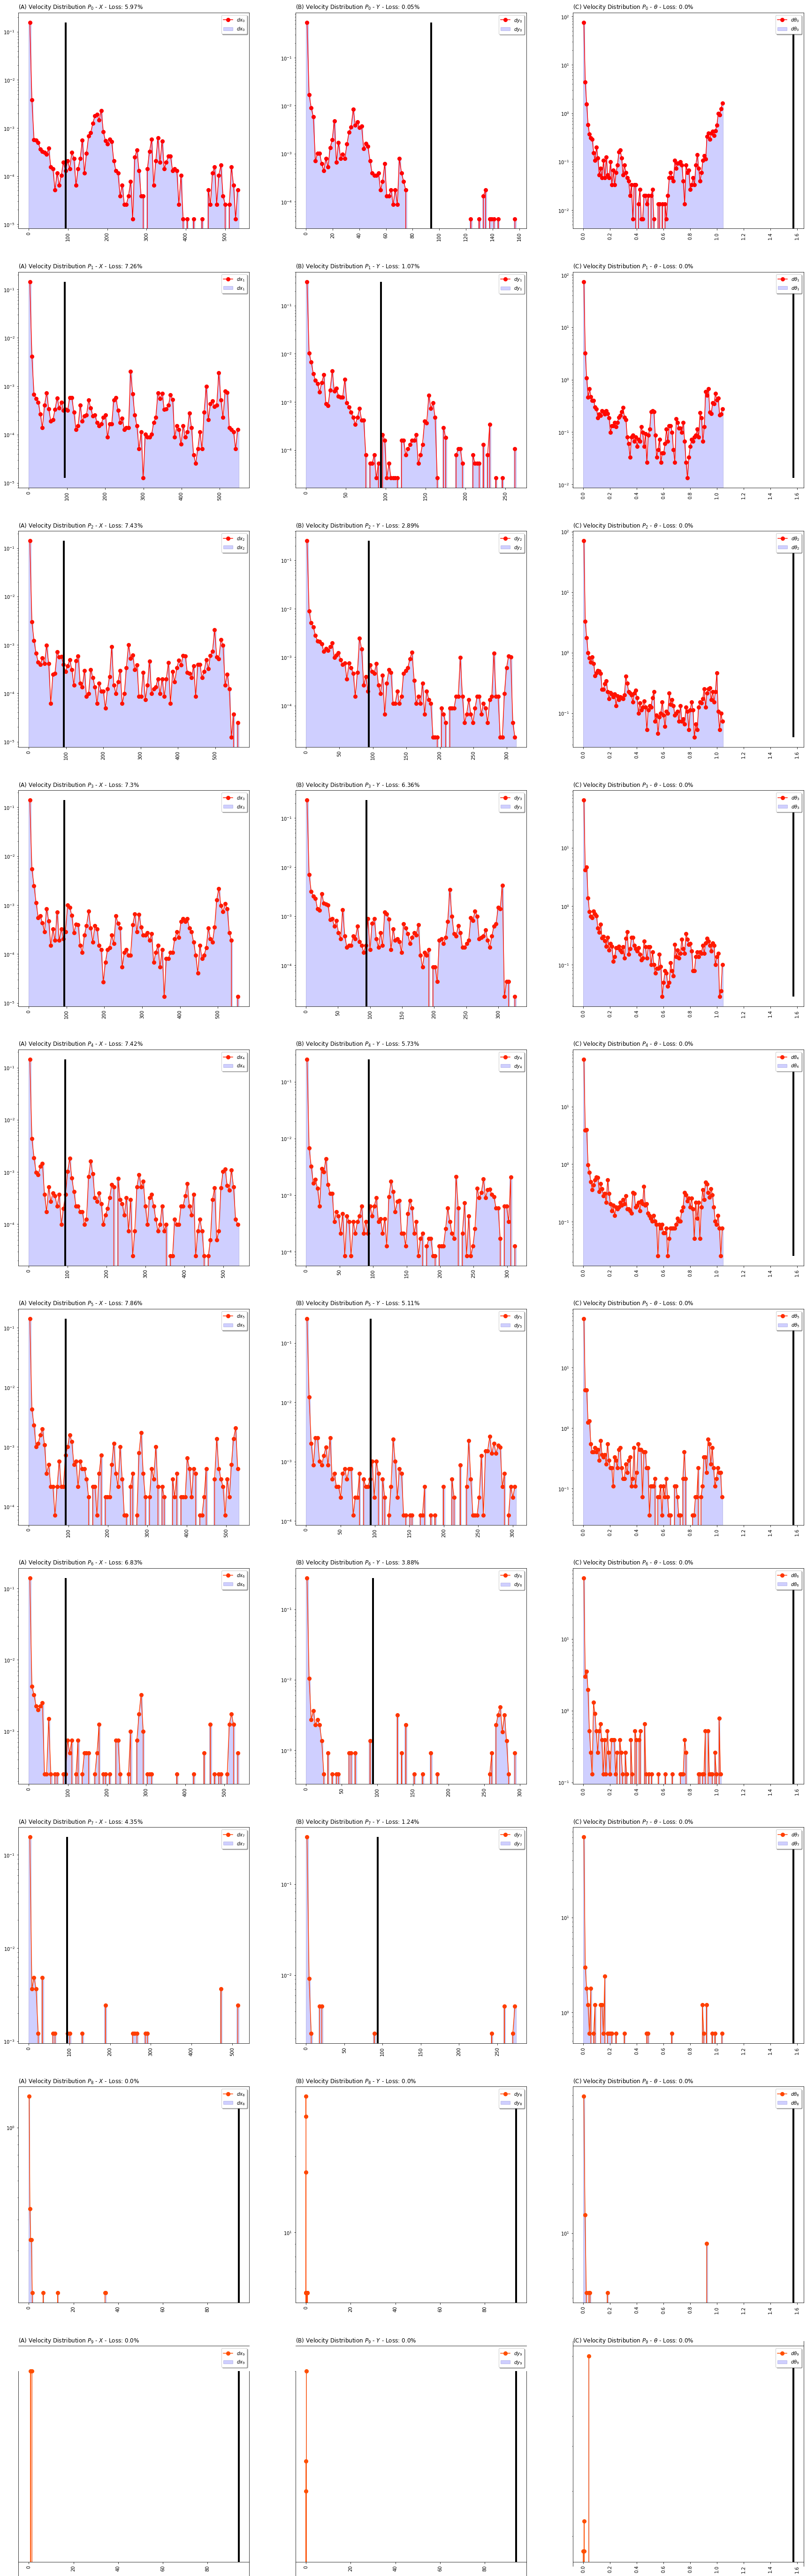

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,6
1,3,3309
2,4,23219
3,5,24345
4,6,11238
5,7,4102
6,8,1080
7,9,189
8,10,50


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 53.709606414878465 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.008884
1,3,False,False,False,4.591489
2,3,False,True,False,0.054784
3,3,True,False,False,0.093281
4,3,True,True,False,0.159910
5,4,False,False,False,31.872427
6,4,False,True,False,0.506382
7,4,True,False,False,1.175634
8,4,True,True,False,0.824721
9,5,False,False,False,33.205011


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 9.349680220435618 
	- Angle: 53.709606414878465 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.004630058338735068%
Final loss data X-axis: 1.0255579220298177%
Final loss data Y-axis: 0.7384943050282433%
Final loss data Angle : 0.2569682377997963%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,2,True,True,True,0.004630
1,3,False,False,False,0.037040
2,3,False,False,True,0.381980
3,3,False,True,False,0.055561
4,3,False,True,True,0.550977
5,3,True,False,True,0.319474
6,3,True,True,False,0.164367
7,3,True,True,True,98.485971


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 9.349680220435618 
	- Angle: 53.709606414878465 



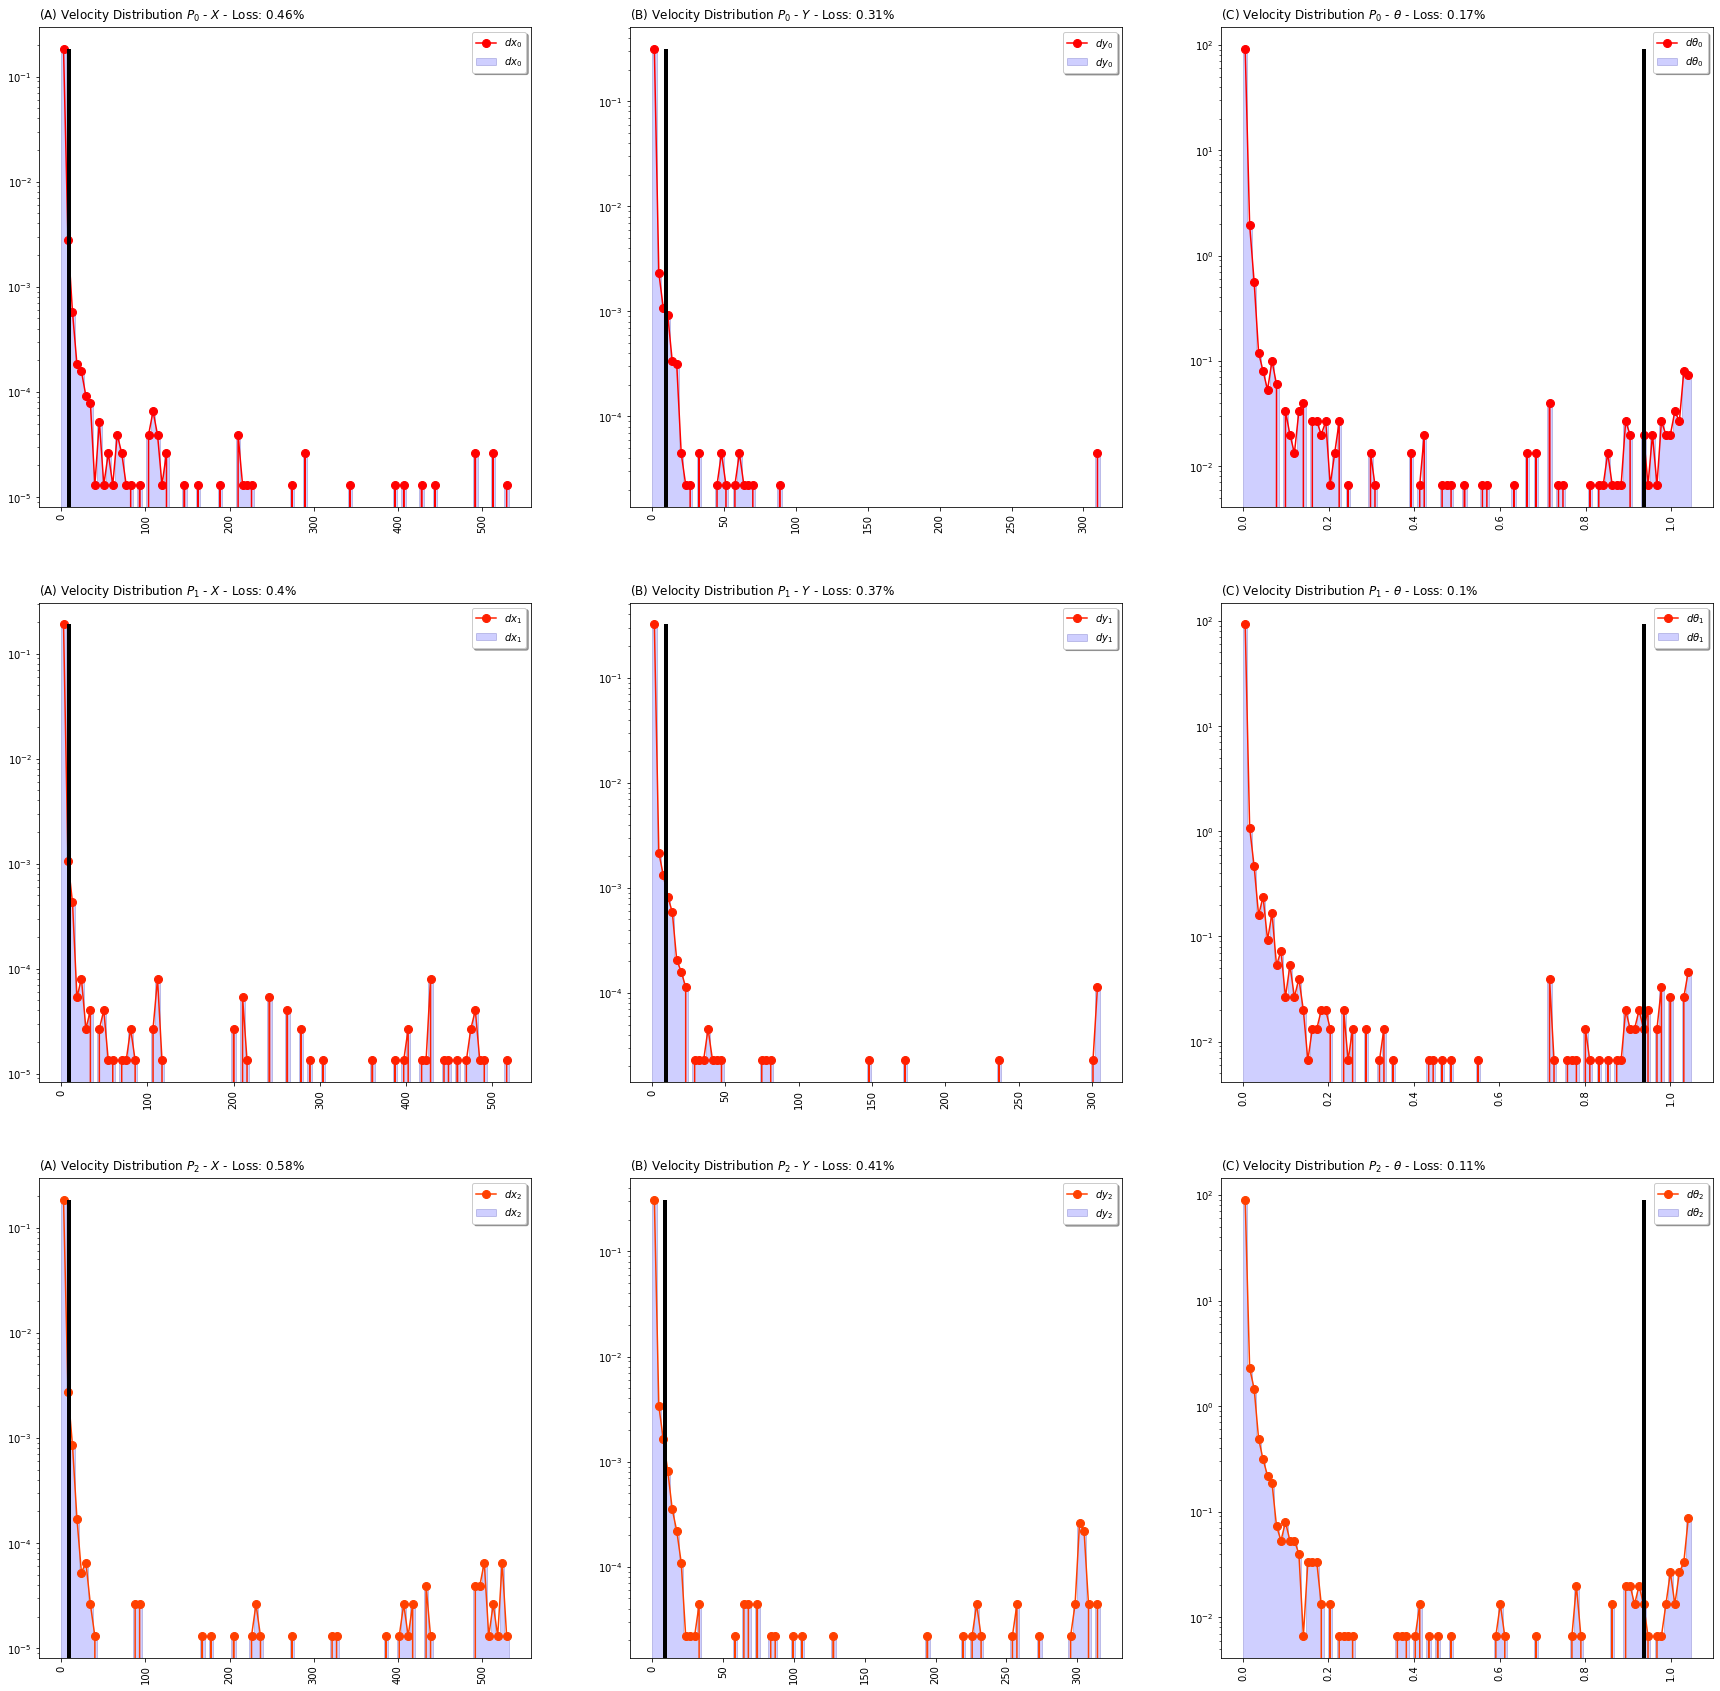

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,468.098850,117.478943,463.228764,120.121186,NaN,468.098850,117.478943,NaN,468.098850,117.478943,-1.505623,16004.0,242.117413,90.972940,0.926726,3,NaN,NaN,NaN,NaN,False,False,False
1103,1,0,1135.494492,807.028661,1131.088337,800.919165,0.0,1211.000000,734.000000,0.682353,1184.000000,785.000000,1.558524,19155.0,257.751641,100.560129,0.920754,3,NaN,NaN,NaN,NaN,False,False,False
2207,2,0,1139.988787,976.742362,1130.893405,973.923111,0.0,1023.000000,916.000000,0.690196,1041.000000,939.000000,-1.286319,14893.0,237.484308,86.564590,0.931201,3,NaN,NaN,NaN,NaN,False,False,False
3311,0,3,468.136502,117.460952,463.245766,120.102711,NaN,468.136502,117.460952,NaN,468.136502,117.460952,-1.505623,16004.0,242.117413,90.972940,0.926726,3,3.0,0.012550,-0.005997,0.0,False,False,False
3312,1,3,1135.332620,807.164417,1130.744017,801.158394,0.0,1211.000000,734.000000,0.682353,1114.500000,787.000000,1.558524,19155.0,257.751641,100.560129,0.920754,3,3.0,-0.053957,0.045252,0.0,False,False,False
3313,2,3,1139.988787,976.742362,1130.893405,973.923111,0.0,1023.000000,916.000000,0.690196,1041.000000,939.000000,-1.286319,14893.0,237.484308,86.564590,0.931201,3,3.0,0.000000,0.000000,0.0,False,False,False
3314,0,6,468.207010,117.441100,463.336337,120.113441,NaN,468.207010,117.441100,NaN,468.207010,117.441100,-1.505623,16004.0,242.117413,90.972940,0.926726,3,3.0,0.023503,-0.006617,0.0,False,False,False
3315,1,6,1135.261518,807.286742,1130.647358,801.330887,0.0,1210.000000,734.500000,0.682353,1148.750000,793.000000,1.558524,19155.0,257.751641,100.560129,0.920754,3,3.0,-0.023701,0.040775,0.0,False,False,False
3316,2,6,1139.988787,976.742362,1130.893405,973.923111,0.0,1023.000000,916.000000,0.690196,1041.000000,939.000000,-1.286319,14893.0,237.484308,86.564590,0.931201,3,3.0,0.000000,0.000000,0.0,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_3m_0f_240214_2_c.zip'